<a href="https://colab.research.google.com/github/ogundipe/AkinwaleDataScience/blob/master/Assignment_modeling_in_KMeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install scikit-learn-extra

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.7 MB/s eta 0:00:00


In [2]:
import os
import math
import datetime
import numpy as np
import plotly as py
import pandas as pd
import seaborn as sns
from scipy import stats
import seaborn as seaborn
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import plotly.express as px
plt.rcParams['figure.figsize'] = [10,6]
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D

In [5]:
df = pd.read_csv('/content/Assignment_data.csv')
print(df.head(),'\n')
print(df.info(),'\n')
print(df.describe(),'\n')

  InvoiceNo StockCode                 Description  Quantity       InvoiceDate  \
0    556536    47310M  SMALL POP BOX FUNKY MONKEY         4   6/13/2011 12:36   
1    547350     21704     BAG 250g SWIRLY MARBLES        12   3/22/2011 12:05   
2    556932    90200A  PURPLE SWEETHEART BRACELET         1   6/15/2011 15:41   
3    572994     22593      CHRISTMAS GINGHAM STAR        12  10/27/2011 11:10   
4    537399     20658   RED RETROSPOT LUGGAGE TAG         2  12/06/2010 14:31   

   UnitPrice  CustomerID         Country  
0       1.25     17795.0  United Kingdom  
1       0.85     17272.0  United Kingdom  
2       4.15         NaN  United Kingdom  
3       0.85     17684.0  United Kingdom  
4       1.25     13030.0  United Kingdom   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119 entries, 0 to 1118
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    1119 non-null   object 
 1   StockCode    111

In [6]:
print(len(df))

1119


In [8]:
for i in df['Quantity'].unique():
  print(i)

4
12
1
2
24
16
100
-8
6
8
10
160
3
5
-2
-12
9
20
48
96
7
36
30
-4
40
25
-11
28
-151
-6
102
50
-96
11
18
204
384
200
23
120
72
19
15
-16
-1
125
-9
-10
-48
-3
64
396
14


I need to input a function to remove negatives in Quantity

In [13]:
def fix_negative(x) :
  if x[0]== "-":
    return float(x[1 :])
  else:
    return float(x)

Eliminating neagative values in Quanity

In [14]:
df['Quantity'] = df['Quantity'] .astype(str)
df['Quantity'] = df['Quantity'] .apply(fix_negative)

Next step is to check for missing values

In [15]:
df.isna() .sum()

InvoiceNo        0
StockCode        0
Description      2
Quantity         0
InvoiceDate      0
UnitPrice        0
CustomerID     278
Country          0
dtype: int64

We need to remove the blank values in Description and CustomerID, and then check for empty values again

In [16]:
df=df.dropna()

df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [17]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,841.000000,841.000000,841.000000
mean,11.800238,3.737170,15271.910820
std,26.694534,20.801132,1687.458069
min,1.000000,0.120000,12359.000000
25%,2.000000,1.250000,14002.000000
50%,5.000000,1.950000,15068.000000
75%,12.000000,4.150000,16729.000000
max,396.000000,600.000000,18259.000000


From the analysis above, it was found that there were outliers in the quantity and unit prizes. So letus Detect and resolve the outliers

<Axes: ylabel='Quantity'>

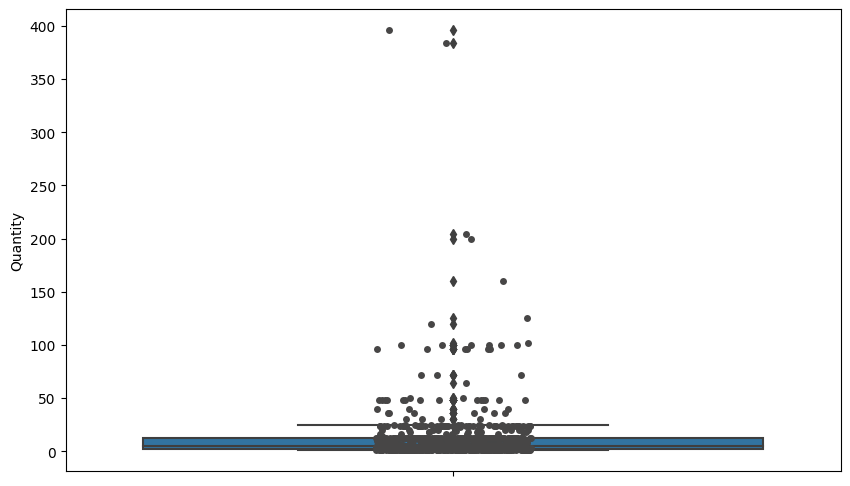

In [30]:
sns.boxplot( y='Quantity',data=df)
sns.stripplot(y='Quantity',data=df, color="#474646")

<Axes: ylabel='Quantity'>

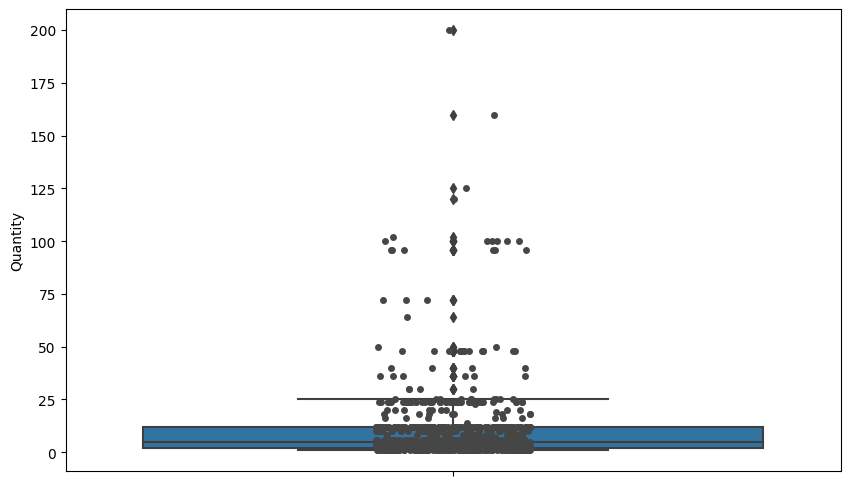

In [34]:
outliers_indices = df.loc[df['Quantity']>250].index
df = df.drop(outliers_indices)
sns.boxplot( y='Quantity',data=df)
sns.stripplot(y='Quantity',data=df, color="#474646")

<Axes: ylabel='UnitPrice'>

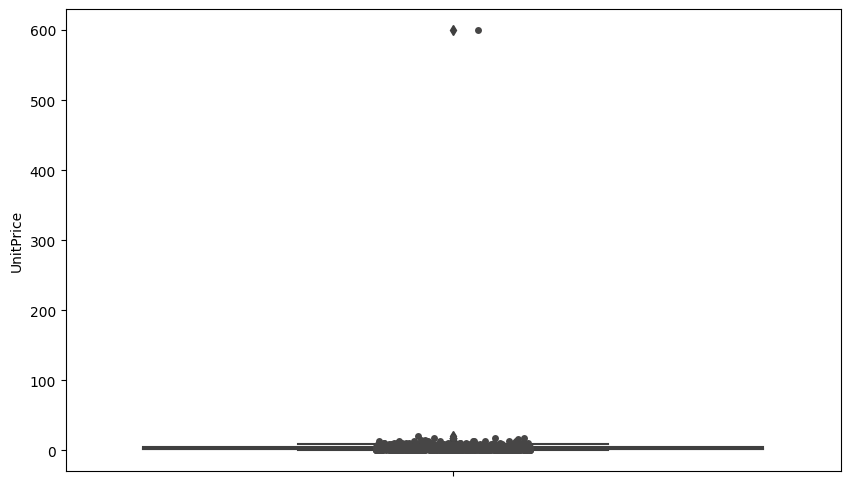

In [35]:
sns.boxplot( y='UnitPrice',data=df)
sns.stripplot(y='UnitPrice',data=df, color="#474646")

<Axes: ylabel='UnitPrice'>

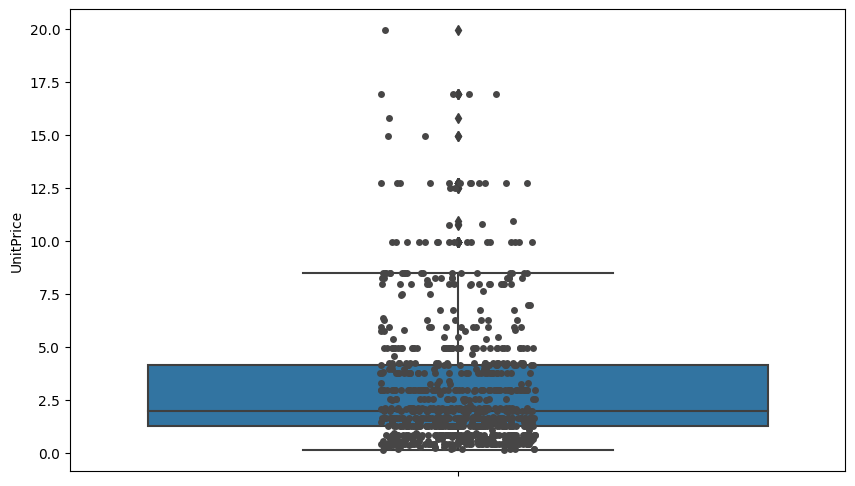

In [36]:
outliers_indices = df.loc[df['UnitPrice']>100].index
df= df.drop(outliers_indices)
sns.boxplot( y='UnitPrice',data=df)
sns.stripplot(y='UnitPrice',data=df, color="#474646")

In [37]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,837.000000,837.000000,837.000000
mean,10.679809,3.024337,15266.947431
std,18.114871,2.991581,1685.432468
min,1.000000,0.120000,12359.000000
25%,2.000000,1.250000,14002.000000
50%,5.000000,1.950000,15065.000000
75%,12.000000,4.150000,16729.000000
max,200.000000,19.950000,18259.000000


Data Preprocessing

Change the InvoiceDate column to date format

In [40]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

Changing the InvoiceDate column to date format removes the outlier
Storing the RFM column in the cus_data dataframe

In [41]:
df["TotalSum"] = df["Quantity"] * df["UnitPrice"]
snapshot_date = max(df.InvoiceDate) + datetime.timedelta(days=1)

cus_data = df.groupby(['CustomerID']).agg({'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
                                            'InvoiceNo': 'count','TotalSum': 'sum'})
cus_data.rename(columns = {'InvoiceDate': 'Recency','InvoiceNo': 'Frequency',
                            'TotalSum': 'Monetary'}, inplace=True)

In [44]:
cus_data.head()

,Recency,Frequency,Monetary
CustomerID,,,
12359.0,305,1,17.00
12362.0,44,1,17.25
12365.0,291,1,12.50
12378.0,130,1,15.00
12380.0,22,2,174.42


In [45]:
cus_data.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 619 entries, 12359.0 to 18259.0
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    619 non-null    int64  
 1   Frequency  619 non-null    int64  
 2   Monetary   619 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 19.3 KB


Normalize data with minmacscaler, and Check the normalization results

In [46]:
scaler = MinMaxScaler()
customers_norm = scaler.fit_transform(cus_data)

customers_norm

array([[0.8172043 , 0.        , 0.01869734],
       [0.1155914 , 0.        , 0.01897707],
       [0.77956989, 0.        , 0.01366215],
       ...,
       [0.55376344, 0.        , 0.02787258],
       [0.58064516, 0.        , 0.01964843],
       [0.22580645, 0.        , 0.01645948]])

Dataframe format of normalized data

In [47]:
customers_df = pd.DataFrame(customers_norm, columns=cus_data.columns)
customers_df

,Recency,Frequency,Monetary
0,0.817204,0.000000,0.018697
1,0.115591,0.000000,0.018977
2,0.779570,0.000000,0.013662
3,0.346774,0.000000,0.016459
4,0.056452,0.083333,0.194839
...,...,...,...
614,0.677419,0.000000,0.019816
615,0.250000,0.000000,0.055063
616,0.553763,0.000000,0.027873
617,0.580645,0.000000,0.019648


In [48]:
customers_df.describe()

,Recency,Frequency,Monetary
count,619.000000,619.000000,619.000000
mean,0.376348,0.029348,0.029764
std,0.301526,0.084487,0.064239
min,0.000000,0.000000,0.000000
25%,0.099462,0.000000,0.007323
50%,0.290323,0.000000,0.016459
75%,0.615591,0.000000,0.027481
max,1.000000,1.000000,1.000000


Modeling Clustering
Finding the best K by using the elbow method

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

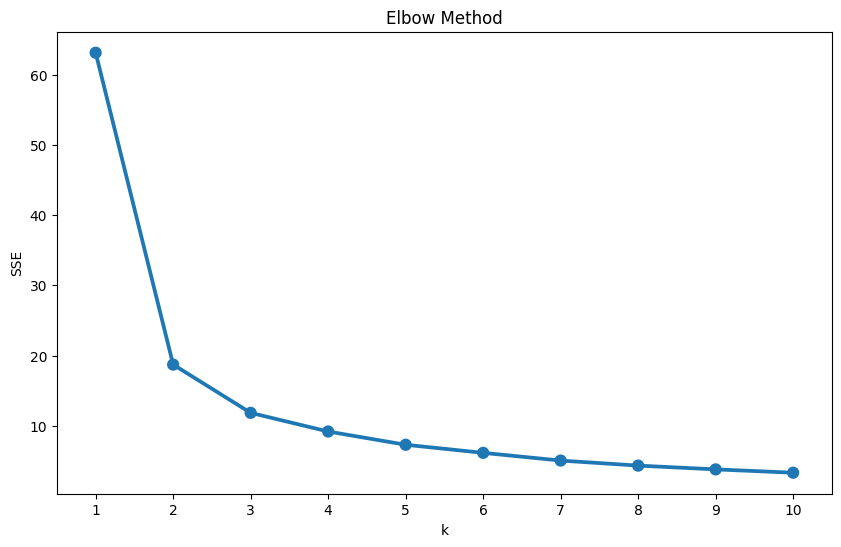

In [53]:
sse = {}
for k in range(1, 11):
  kmeans = KMeans(n_clusters=k, random_state=7)
  kmeans.fit(customers_df)
  sse[k] = kmeans.inertia_

plt.title('Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show() 

From the graph above, the K value taken is K=3

In [54]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=7)
kmedoids = KMedoids(n_clusters=3)
models = [kmeans, kmedoids]
name = ["K-Means Clustering", "K-Medoids Clustering", "Accelerated K-Means"]
for i in range(2):
    models[i].fit(customers_df)
    score = silhouette_score(customers_df, models[i].labels_, metric='euclidean') 
    print(name[i], " Silhouette Score = ", score)

K-Means Clustering  Silhouette Score =  0.5595806025002882
K-Medoids Clustering  Silhouette Score =  0.559271583118866


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


From the results of the comparison of the silhouette score values ​​above, the K-Means algorithm was chosen to perform customer segmentation

Fit model kmeans cluster

In [55]:
kmeans.fit(customers_df)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3, random_state=7)

Add cluster column, and Displays the average of each cluster

```
# This is formatted as code
```



In [56]:
cus_data['cluster'] = kmeans.labels_

cus_data.groupby('cluster').agg({
    'Recency' : 'mean',
    'Frequency' : 'mean',
    'Monetary' : ['mean', 'count']}).round(2)

Recency Frequency Monetary      
           mean      mean     mean count
cluster                                 
0        307.28      1.05    17.39   142
1         44.88      1.54    31.30   313
2        180.48      1.25    26.70   164

**Visualizing (KMeans)**

Look at the number of customers for each cluster

In [57]:
cus_data.cluster.value_counts()

1    313
2    164
0    142
Name: cluster, dtype: int64

In [58]:
fig = px.pie(df, values = cus_data['cluster'].value_counts(), 
             names = (cus_data['cluster'].value_counts()).index, 
             title = 'Predicted Clusters Distribution')
fig.show()

Save predicted result, and Convert Dataframe to numpy array after importing dataframe

In [59]:
y_kmeans=kmeans.fit_predict(customers_df)
customers_np = customers_df.values

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Create a visualization of all clusters

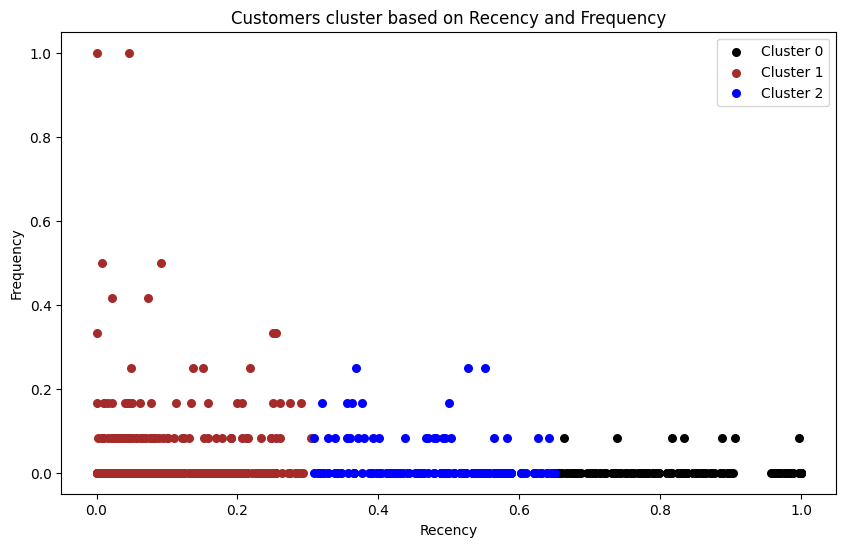

In [66]:
plt.scatter(customers_np[y_kmeans == 0, 0], customers_np[y_kmeans == 0, 1], s = 30, c = 'black', label = 'Cluster 0')
plt.scatter(customers_np[y_kmeans == 1, 0], customers_np[y_kmeans == 1, 1], s = 30, c = 'brown', label = 'Cluster 1')
plt.scatter(customers_np[y_kmeans == 2, 0], customers_np[y_kmeans == 2, 1], s = 30, c = 'blue', label = 'Cluster 2')
plt.title('Customers cluster based on Recency and Frequency')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.legend()
plt.show()

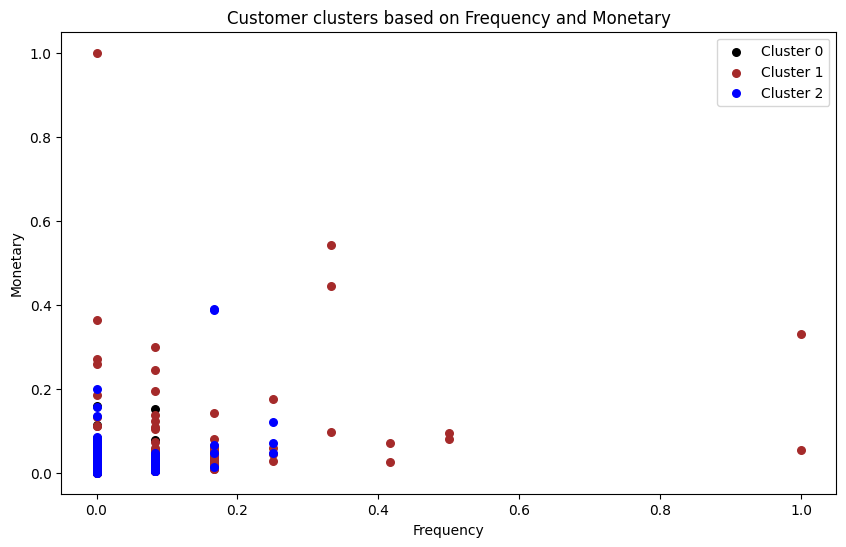

In [68]:
plt.scatter(customers_np[y_kmeans == 0, 1], customers_np[y_kmeans == 0, 2], s = 30, c = 'black', label = 'Cluster 0')
plt.scatter(customers_np[y_kmeans == 1, 1], customers_np[y_kmeans == 1, 2], s = 30, c = 'brown', label = 'Cluster 1')
plt.scatter(customers_np[y_kmeans == 2, 1], customers_np[y_kmeans == 2, 2], s = 30, c = 'blue', label = 'Cluster 2')
plt.title('Customer clusters based on Frequency and Monetary')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.legend()
plt.show()

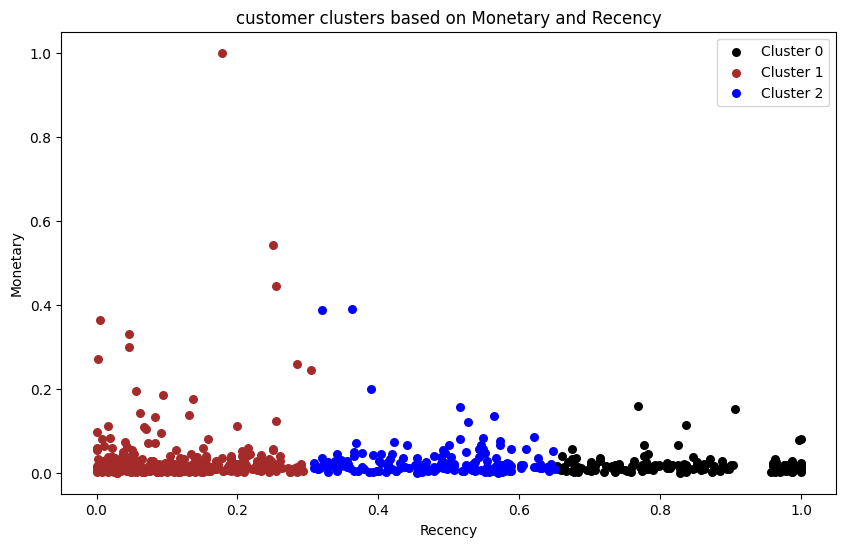

In [69]:
plt.scatter(customers_np[y_kmeans == 0, 0], customers_np[y_kmeans == 0, 2], s = 30, c = 'black', label = 'Cluster 0')
plt.scatter(customers_np[y_kmeans == 1, 0], customers_np[y_kmeans == 1, 2], s = 30, c = 'brown', label = 'Cluster 1')
plt.scatter(customers_np[y_kmeans == 2, 0], customers_np[y_kmeans == 2, 2], s = 30, c = 'blue', label = 'Cluster 2')
plt.title('customer clusters based on Monetary and Recency')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.legend()
plt.show()

In [70]:
plot3d_1 = go.Scatter3d(
    x= customers_df['Recency'],
    y= customers_df['Frequency'],
    z= customers_df['Monetary'],

    mode = 'markers'
)

data = [plot3d_1]
layout = go.Layout(

#     )
    title= '3D Data',
    scene = dict(
            xaxis = dict(title  = 'Recency'),
            yaxis = dict(title  = 'Frequency'),
            zaxis = dict(title  = 'Monetary')
        )
)
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)